# Text Mining Analysis of Amazon Product Reviews

For this case study, we will be using the [Amazon Product Reviews](https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews) dataset.

This Dataset contains 568,454 rows and 10 columns.

In [1]:
#Import necessary libraries

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /Users/vc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/vc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Load & display product sentiment dataset

senti_df = pd.read_csv('Reviews.csv')
senti_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


The dataset does not have a polarity column. We will create one using the score column.
We will go ahead with an assumption that if the score is greater than 3, the sentiment is positive and if the score is less than 3, the sentiment is negative.

In [3]:
senti_df['Polarity'] = senti_df['Score'].apply(lambda x: 1 if x > 3 else 0)
senti_df['Sentence'] = senti_df['Text']

In [4]:
senti_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
 10  Polarity                568454 non-null  int64 
 11  Sentence                568454 non-null  object
dtypes: int64(6), object(6)
memory usage: 52.0+ MB


Polarity: -1=positive, 0=negative

In [5]:
#Keep only the Polarity and Sentence columns

senti_df = senti_df[['Sentence', 'Polarity', 'ProductId']].copy()

Now the dataset has only the necessary columns

In [6]:
#Create a new DataFrame with only the 'Sentences' column
sentences_df = senti_df[['Sentence']].copy()

#Display the head of the new DataFrame
print(sentences_df.head())

                                            Sentence
0  I have bought several of the Vitality canned d...
1  Product arrived labeled as Jumbo Salted Peanut...
2  This is a confection that has been around a fe...
3  If you are looking for the secret ingredient i...
4  Great taffy at a great price.  There was a wid...


In [7]:
#Remove HTML <br /> tags

sentences_df['Sentence'] = sentences_df['Sentence'].str.replace('<br />', ' ')

Since the dataset is very large, we are grouping it by ProductID and selecting the first 200 reviews

In [8]:
#Group by 'ProductId' and filter to select only groups with at least 20 reviews
filtered_df = senti_df.groupby('ProductId').filter(lambda x: len(x) >= 20)

#Get the top 10 products from the filtered DataFrame
grouped_df = filtered_df.groupby('ProductId').head(10)

#Ensure the total number of rows is 200
grouped_df = grouped_df.head(200)

In [9]:
#Verifying the number of product=20
unique_entries = grouped_df['ProductId'].unique()

print("Unique entries in the column:")
print(unique_entries)

Unique entries in the column:
['B000G6RYNE' 'B002BCD2OG' 'B000G6MBX2' 'B000HDMUQ2' 'B000ER6YO0'
 'B001E6KBSK' 'B0025ULYKI' 'B005O072PC' 'B000WNJ73Q' 'B00068PCTU'
 'B000E7WM0K' 'B001CWZXIY' 'B001RVFDOO' 'B0016PKA1C' 'B001E5E29A'
 'B002C4HZ00' 'B0089SPDUW' 'B002JX7GVM' 'B000ED9LDU' 'B000EGX2EG']


In [10]:
#Create new dataframe for stop words
stp_words = stopwords.words('english')

#Create new function "clean_sentence"
def clean_sentence(Sentence): 
  cleansentence = " ".join(word for word in Sentence.
                       split() if word not in stp_words)
  return cleansentence 
 
grouped_df['Sentence'] = grouped_df['Sentence'].apply(clean_sentence)

In [11]:
#Remove HTML <br /> tags

grouped_df['Sentence'] = grouped_df['Sentence'].str.replace('<br />', ' ')

In [12]:
#Display dataset

grouped_df.head()

,Sentence,Polarity,ProductId
422,"Great cutting back fat, resemble regular chips...",1,B000G6RYNE
423,I never met Kettle brand chip I like. These ch...,1,B000G6RYNE
424,After buying bags one time (at hefty markup) n...,1,B000G6RYNE
425,"I buy mostly vending, size bag important. Kett...",1,B000G6RYNE
426,Glad find one ounce size bag seems bit less fu...,1,B000G6RYNE


In [13]:
#Display stop words

print(stp_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [14]:
#Display clean sentence data

grouped_df.head()

,Sentence,Polarity,ProductId
422,"Great cutting back fat, resemble regular chips...",1,B000G6RYNE
423,I never met Kettle brand chip I like. These ch...,1,B000G6RYNE
424,After buying bags one time (at hefty markup) n...,1,B000G6RYNE
425,"I buy mostly vending, size bag important. Kett...",1,B000G6RYNE
426,Glad find one ounce size bag seems bit less fu...,1,B000G6RYNE


In [15]:
#Count the polarity

grouped_df['Polarity'].value_counts()

Polarity
1    154
0     46
Name: count, dtype: int64

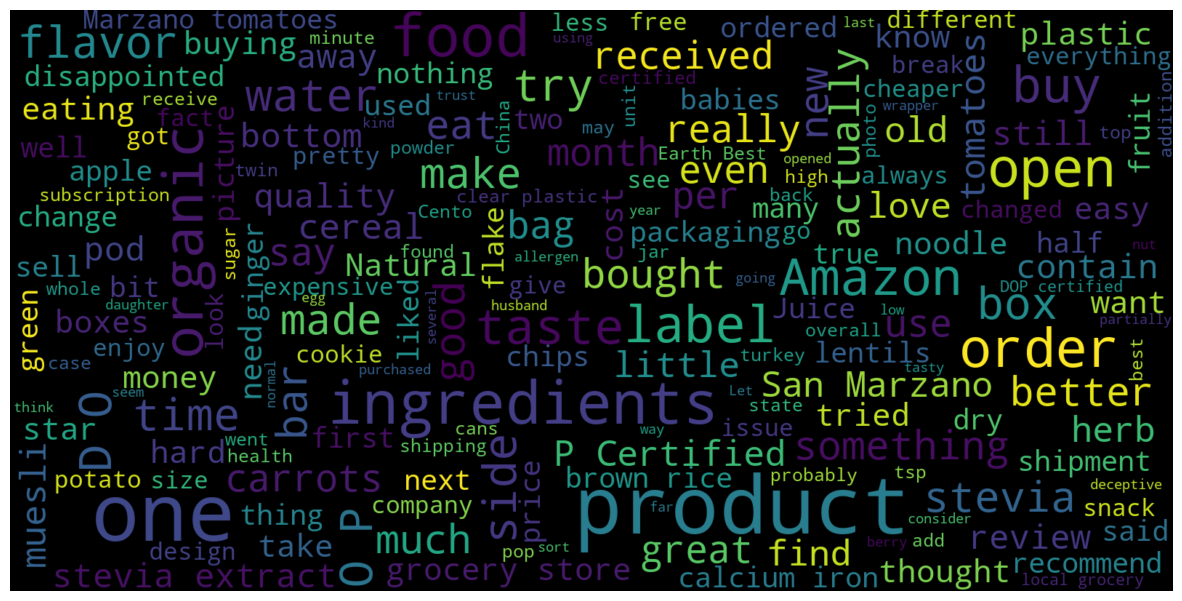

In [16]:
#Display word cloud -- negative

consolidated = ' '.join(word for word in grouped_df['Sentence'][grouped_df['Polarity'] == 0].astype(str))
wordCloud = WordCloud(width = 1600,height = 800,random_state = 21,max_font_size = 110)

plt.figure(figsize = (15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation = 'bilinear')
plt.axis('off')
plt.show()

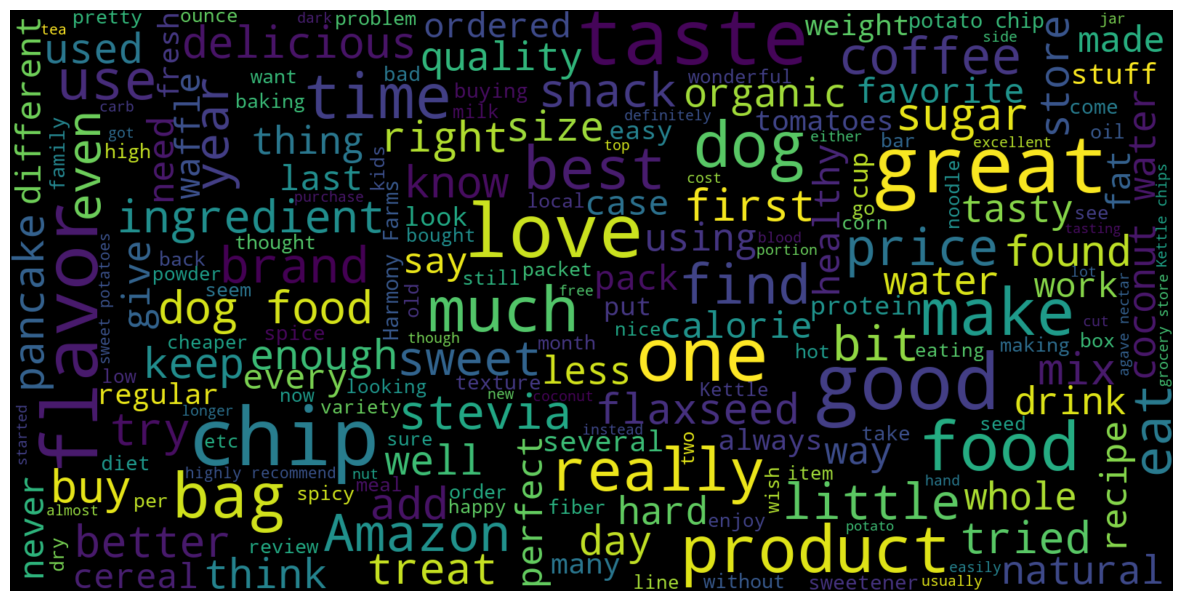

In [17]:
#Display word cloud -- positive

consolidated = ' '.join(word for word in grouped_df['Sentence'][grouped_df['Polarity'] == 1].astype(str))
wordCloud = WordCloud(width = 1600,height = 800,random_state = 21,max_font_size = 110)

plt.figure(figsize = (15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation = 'bilinear')
plt.axis('off')
plt.show()

### Feature Extraction - Bag of Words

In [18]:
#Text Tokenization -- Using TF-IDF Vectorizer
cv = CountVectorizer()
X = cv.fit_transform(grouped_df['Sentence']).toarray()
y = grouped_df['Polarity']

In [19]:
#Splitting the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

print(X.shape, y.shape)

(200, 2660) (200,)


### Model: Logical Regression

In [20]:
#Create and train the Logistic Regression model with train data
LR = LogisticRegression()
 
#Model fitting
LR.fit(X_train,y_train)
 
#Testing the model
pred = LR.predict(X_test)
 
#Model accuracy
print('Logical Regression Accuracy:', accuracy_score(y_test,pred))

Logical Regression Accuracy: 0.8666666666666667


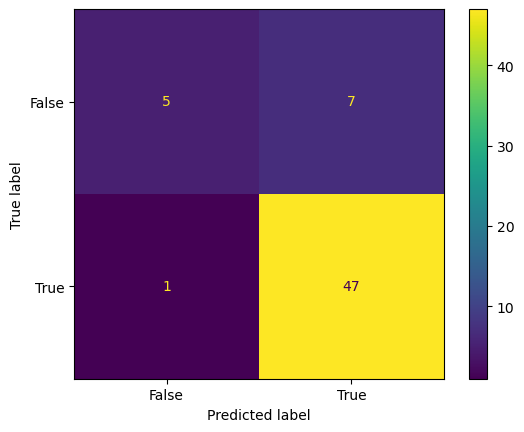

In [21]:
#Display the confusion matrix -- with test data

matrix = confusion_matrix(y_test, LR.predict(X_test))
matrix_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [False, True])
matrix_display.plot()
plt.show()

In [22]:
#Apply the model on the entire dataset for analysis
grouped_df['predicted_polarity'] = LR.predict(X)

#Identify instances where predictions were incorrect
incorrect_predictions = grouped_df[grouped_df['Polarity'] != grouped_df['predicted_polarity']]

for index, row in incorrect_predictions.head(5).iterrows():
    modified_sentence = row['Sentence']
    row_index = row.name
    
    if row_index != 0:
        #If the index is found, get the corresponding sentence
        original_sentence = sentences_df.loc[row_index, 'Sentence']
    else:
        original_sentence = "Not found in sentences_df"
    
    print(f"Actual Polarity: {row['Polarity']}\nPredicted Polarity: {row['predicted_polarity']}")
    print(f"Original Sentence: {original_sentence}")
    print(f"Stop Word removed : {modified_sentence}")
    print("\n")

Actual Polarity: 0
Predicted Polarity: 1
Original Sentence: 4 bags of chips were open when I received the shipment. I am hoping that the chips were blew open during shipment in flight.  No more chips for me through Amazon.  Otherwise, the chips are good to eat and very salty.
Stop Word removed : 4 bags chips open I received shipment. I hoping chips were blew open shipment flight. No chips Amazon. Otherwise, the chips good eat salty.


Actual Polarity: 0
Predicted Polarity: 1
Original Sentence: We have ordered Uncle Rays BBQ chips many times before. Always been pleased, except this order!  Just NOT the same Seasoning as usual. Generally lacked much for taste! Not sure if they have reduced the seasoning, in their processing? But out of case we bought, we have opened and thrown away 3 bags already, VERY disappointed with this order!
Stop Word removed : We ordered Uncle Rays BBQ chips many times before. Always pleased, except order! Just NOT same Seasoning usual. Generally lacked much tast

### Model: Naive Bayes

In [23]:
#Create and train the Multinomial Naive Bayes model with train data
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

#Evaluate the model
accuracy = MNB.score(X_test, y_test)
print(f"Naive Bayes Accuracy: {accuracy}")

Naive Bayes Accuracy: 0.9


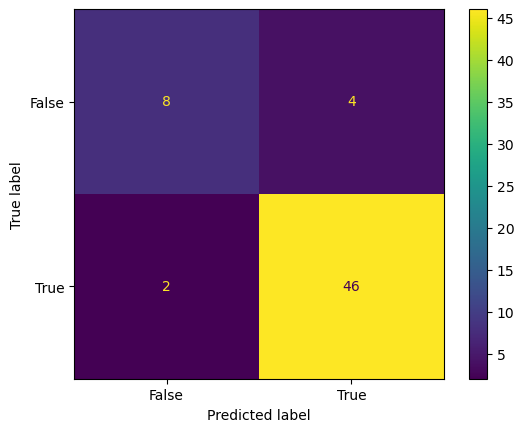

In [24]:
#Display the confusion matrix -- with test data

matrix = confusion_matrix(y_test, MNB.predict(X_test))
matrix_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [False, True])
matrix_display.plot()
plt.show()

In [25]:
#Apply the model on the entire dataset for analysis
grouped_df['predicted_polarity'] = MNB.predict(X)

#Identify instances where predictions were incorrect
incorrect_predictions = grouped_df[grouped_df['Polarity'] != grouped_df['predicted_polarity']]

for index, row in incorrect_predictions.head(5).iterrows():
    modified_sentence = row['Sentence']
    row_index = row.name
    
    if row_index != 0:
        #If the index is found, get the corresponding sentence
        original_sentence = sentences_df.loc[row_index, 'Sentence']
    else:
        original_sentence = "Not found in sentences_df"
    
    print(f"Actual Polarity: {row['Polarity']}\nPredicted Polarity: {row['predicted_polarity']}")
    print(f"Original Sentence: {original_sentence}")
    print(f"Stop Word removed : {modified_sentence}")
    print("\n")

Actual Polarity: 0
Predicted Polarity: 1
Original Sentence: 4 bags of chips were open when I received the shipment. I am hoping that the chips were blew open during shipment in flight.  No more chips for me through Amazon.  Otherwise, the chips are good to eat and very salty.
Stop Word removed : 4 bags chips open I received shipment. I hoping chips were blew open shipment flight. No chips Amazon. Otherwise, the chips good eat salty.


Actual Polarity: 0
Predicted Polarity: 1
Original Sentence: We have ordered Uncle Rays BBQ chips many times before. Always been pleased, except this order!  Just NOT the same Seasoning as usual. Generally lacked much for taste! Not sure if they have reduced the seasoning, in their processing? But out of case we bought, we have opened and thrown away 3 bags already, VERY disappointed with this order!
Stop Word removed : We ordered Uncle Rays BBQ chips many times before. Always pleased, except order! Just NOT same Seasoning usual. Generally lacked much tast

### Model : Neural Network

In [26]:
#Create and train the Neural Network model with train data
NN = Sequential()
NN.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
NN.add(Dense(1, activation='sigmoid'))

NN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Model fitting
NN.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

#Testing the model
pred_nn = (NN.predict(X_test) > 0.5).astype("int32").flatten()

#Model accuracy
accuracy_nn = accuracy_score(y_test, pred_nn)
print("Neural Network Accuracy:", accuracy_nn)

Epoch 1/10
4/4 [==============================] - 0s 36ms/step - loss: 0.6386 - accuracy: 0.7381 - val_loss: 0.6728 - val_accuracy: 0.7857
Epoch 2/10
4/4 [==============================] - 0s 6ms/step - loss: 0.4327 - accuracy: 0.9206 - val_loss: 0.7419 - val_accuracy: 0.7143
Epoch 3/10
4/4 [==============================] - 0s 7ms/step - loss: 0.3212 - accuracy: 0.9444 - val_loss: 0.8266 - val_accuracy: 0.7143
Epoch 4/10
4/4 [==============================] - 0s 7ms/step - loss: 0.2404 - accuracy: 0.9762 - val_loss: 0.9190 - val_accuracy: 0.7143
Epoch 5/10
4/4 [==============================] - 0s 7ms/step - loss: 0.1835 - accuracy: 0.9921 - val_loss: 1.0181 - val_accuracy: 0.7143
Epoch 6/10
4/4 [==============================] - 0s 7ms/step - loss: 0.1410 - accuracy: 1.0000 - val_loss: 1.1243 - val_accuracy: 0.7143
Epoch 7/10
4/4 [==============================] - 0s 7ms/step - loss: 0.1091 - accuracy: 1.0000 - val_loss: 1.2309 - val_accuracy: 0.7143
Epoch 8/10
4/4 [=================

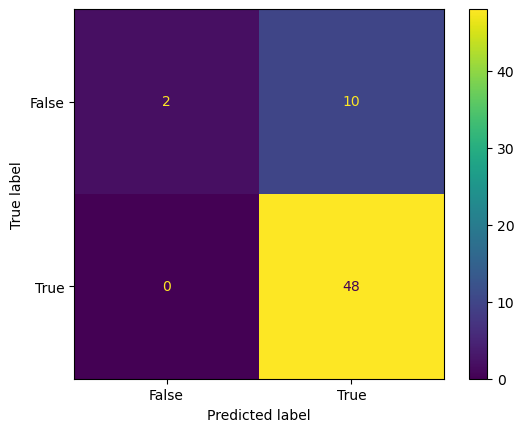

In [27]:
#Display the confusion matrix -- with test data

matrix = confusion_matrix(y_test, pred_nn)
matrix_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [False, True])
matrix_display.plot()
plt.show()

In [28]:
#Apply the model on the entire dataset for analysis
grouped_df['predicted_polarity'] = (NN.predict(X) > 0.5).astype("int32").flatten()

#Identify instances where predictions were incorrect
incorrect_predictions = grouped_df[grouped_df['Polarity'] != grouped_df['predicted_polarity']]

for index, row in incorrect_predictions.head(5).iterrows():
    modified_sentence = row['Sentence']
    row_index = row.name
    
    if row_index != 0:
        #If the index is found, get the corresponding sentence
        original_sentence = sentences_df.loc[row_index, 'Sentence']
    else:
        original_sentence = "Not found in sentences_df"
    
    print(f"Actual Polarity: {row['Polarity']}\nPredicted Polarity: {row['predicted_polarity']}")
    print(f"Original Sentence: {original_sentence}")
    print(f"Stop Word removed : {modified_sentence}")
    print("\n")

7/7 [==============================] - 0s 1ms/step
Actual Polarity: 0
Predicted Polarity: 1
Original Sentence: This product must qualify for some sort of deceptive packaging award. The box only contains 5 bars and the wrappers are smaller than normal, so at least 50% of the interior of the box is air. Then when you unwrap the bar you find they are only about 60% the length of a "normal" snack bar. The rest of it is empty air inside the wrapper. If they were to not include wrappers those 5 bars would occupy less than 25% of the space inside the box.  As far as taste goes they are so-so. On the dry side with a hint of berry flavor. Celiacs, who are used to inferior products, won't be disappointed in the taste of this one.  I've also had their cookies and they suffer from the same sort of deceptive packaging. The picture on the side of the box shows what most of us would consider a normal sized cookie. But when you open the box you find that it mostly contains a plastic tray holding cooki

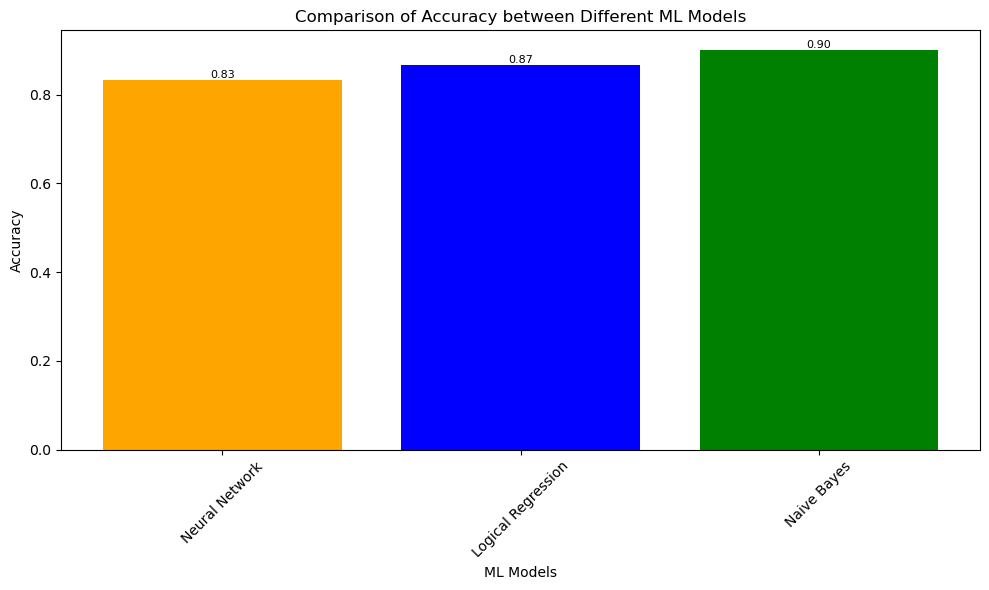

In [30]:
#Compare Accuracy between ML models

#Accuracy values
methods = ['Logical Regression', 'Naive Bayes', 'Neural Network']
accuracy_values = [0.8667, 0.90, 0.8333]

#Sort methods and accuracy_values based on accuracy values in descending order
sorted_data = sorted(zip(methods, accuracy_values), key=lambda x: x[1])
methods_sorted, accuracy_values_sorted = zip(*sorted_data)

#Create bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, accuracy_values_sorted, color=['orange', 'blue', 'green'])
plt.xlabel('ML Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy between Different ML Models')
plt.xticks(rotation=45)

#Add accuracy value on each bar
for bar, value in zip(bars, accuracy_values_sorted):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}', 
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()